**Variational autoencoder (VAE)**

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Set the path for the images

In [0]:
pwd_m = '/content/drive/My Drive/Colab Notebooks/Thesis/data/celeb_faces/male_images/*.jpg'
pwd_f = '/content/drive/My Drive/Colab Notebooks/Thesis/data/celeb_faces/female_images/*.jpg'

Load the related packges

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from sklearn import model_selection 

from keras import layers
from keras import Model

Using TensorFlow backend.


**Functions used to do plotting**

The first function is used to plot the 3-channel image and the other one used to plot the images with 1 channel.

In [0]:
# The Function used to plot 3-Channel images
def Plot_Img(n,k,n_c,images,fig_w,fig_h):
    # n is how many digits we will display
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(k,k,n_c))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [0]:
# The Function used to plot 1-Channel images
def Plot_Img_1c(n,k,images,fig_w,fig_h):
    # n is how many digits we will display
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(k,k))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Read the images and do the training and testing datasets split.

In [0]:
# Read the image from the google drive and display two examples.
img_m = glob.glob(pwd_m)
img_f = glob.glob(pwd_f)

img_names_m = model_selection.train_test_split(img_m)
img_names_f = model_selection.train_test_split(img_f)

im_train_m = np.array([mpimg.imread(a) for a in img_names_m[0]])
im_test_m = np.array([mpimg.imread(a) for a in img_names_m[1]])
im_train_f = np.array([mpimg.imread(a) for a in img_names_f[0]])
im_test_f = np.array([mpimg.imread(a) for a in img_names_f[1]])

im_train_m = im_train_m.astype('float32') / 255.
im_test_m = im_test_m.astype('float32') / 255.
im_train_f = im_train_f.astype('float32') / 255.
im_test_f = im_test_f.astype('float32') / 255.

Plot some examples of the images I use here

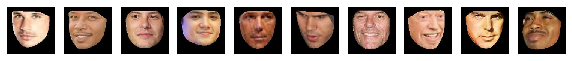

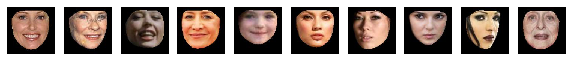

In [7]:
Plot_Img(10,128,3,im_train_m,10,4)
Plot_Img(10,128,3,im_train_f,10,4)

Shape of the training and testing datasets.

In [9]:
im_train = np.concatenate((im_train_m,im_train_f))
im_test = np.concatenate((im_test_m,im_test_f))
print(im_train.shape,im_test.shape)

(750, 128, 128, 3) (250, 128, 128, 3)


**Autoencoder with Latent variable layer**

**Build up Autoencoder Model with a latent variable layer: A FC layer for encoding**

In [10]:
input_dim = [128,128,3] # The length of the input vector
encode_dim = 2 # The length of the compressed data vector after the encoding

Input = layers.Input(shape=(input_dim[0],input_dim[1],input_dim[2]))
x = layers.Conv2D(16,(3,3),activation='relu',padding='same')(Input)
x = layers.MaxPooling2D((2,2),padding='same')(x)
x = layers.Conv2D(32,(3,3),activation='relu',padding='same')(x)
x = layers.MaxPooling2D((2,2),padding='same')(x)
x = layers.Conv2D(64,(3,3),activation='relu',padding='same')(x)
x = layers.MaxPooling2D((2,2),padding='same')(x)
x = layers.Reshape((16*16,64))(x)
encode = layers.Dense(encode_dim,activation='relu')(x)

x = layers.Reshape((16,16,encode_dim))(encode)
x = layers.Conv2D(64,(3,3),activation='relu',padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(32,(3,3),activation='relu',padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(16,(3,3),activation='relu',padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
decode = layers.Conv2D(3,(3,3),activation='sigmoid',padding='same')(x)

simple_auto = Model(Input,decode)
simple_auto.summary()
# Using the 'adam' optimization method with the MSE loss function
simple_auto.compile(optimizer='adam', loss='mean_squared_error') 

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_

Seperate the encoder and the decoder models

In [11]:
# The encoder model
encoder = Model(Input,encode)
# The decoder model
decode_Input = layers.Input(shape=(256,encode_dim))
x = simple_auto.layers[9](decode_Input)
x = simple_auto.layers[10](x)
x = simple_auto.layers[11](x)
x = simple_auto.layers[12](x)
x = simple_auto.layers[13](x)
x = simple_auto.layers[14](x)
x = simple_auto.layers[15](x)
x = simple_auto.layers[16](x)
decoder = Model(decode_Input,x)

print(encoder.summary())
print(decoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
__________

**Set up to use the GPU**

In [12]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Training process and testing evaluation

In [13]:
# Train the model
simple_auto.fit(im_train,im_train,epochs=150,batch_size=25)
# Evaluate the test set
simple_auto.evaluate(im_test,im_test)

Instructions for updating:
Use tf.cast instead.
Epoch 1/150
750/750 [==============================] - 5s 6ms/step - loss: 0.0684
Epoch 2/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0120
Epoch 3/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0085
Epoch 4/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0073
Epoch 5/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0062
Epoch 6/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0056
Epoch 7/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0047
Epoch 8/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0043
Epoch 9/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0042
Epoch 10/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0038
Epoch 11/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0037
Epoch 12/150
750/750 [==========================

0.001964020955376327

In [14]:
FC_values_train = encoder.predict(im_train)
decoded_img_train = decoder.predict(FC_values_train)
FC_values_test = encoder.predict(im_test)
decoded_img_test = decoder.predict(FC_values_test)
print(FC_values_train.shape,FC_values_test.shape)

(750, 256, 2) (250, 256, 2)


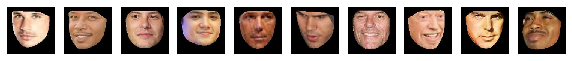

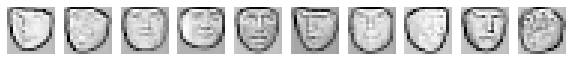

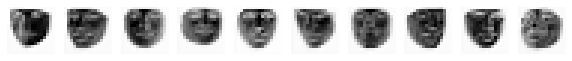

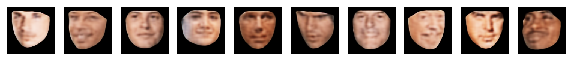

In [15]:
FC_values_train1 = FC_values_train[:,:,0]
FC_values_train2 = FC_values_train[:,:,1]
Plot_Img(10,128,3,im_train,10,4)
Plot_Img_1c(10,16,FC_values_train1,10,4)
Plot_Img_1c(10,16,FC_values_train2,10,4)
Plot_Img(10,128,3,decoded_img_train,10,4)

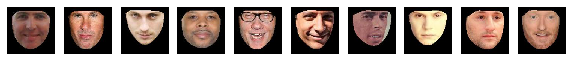

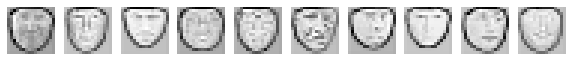

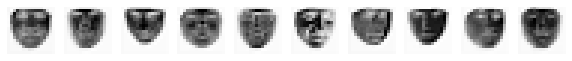

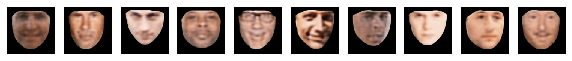

In [16]:
FC_values_test1 = FC_values_test[:,:,0]
FC_values_test2 = FC_values_test[:,:,1]
Plot_Img(10,128,3,im_test,10,4)
Plot_Img_1c(10,16,FC_values_test1,10,4)
Plot_Img_1c(10,16,FC_values_test2,10,4)
Plot_Img(10,128,3,decoded_img_test,10,4)

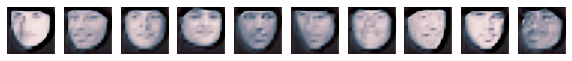

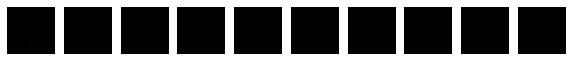

In [17]:
FC_values_train = encoder.predict(im_train)
FC_00 = FC_values_train
FC_00[:,:,0] = 0
decoded_img_00 = decoder.predict(FC_00)
Plot_Img(10,128,3,decoded_img_00,10,4)

FC_values_train = encoder.predict(im_train)
FC_10 = FC_values_train
FC_10[:,:,1] = 0
decoded_img_10 = decoder.predict(FC_10)
Plot_Img(10,128,3,decoded_img_10,10,4)

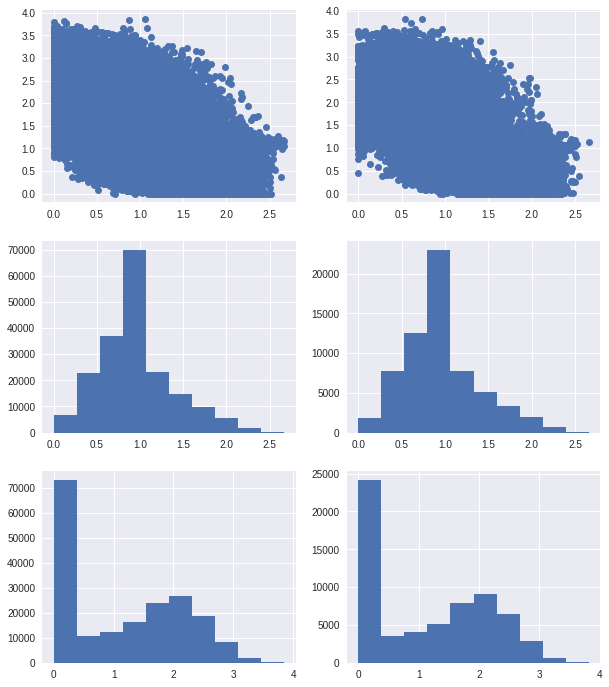

In [18]:
# Dot plots and the histograms of the FC values for the training and testing datasets
plt.figure(figsize=(10, 12))
ax = plt.subplot(3,2,1)
plt.plot(FC_values_train1.reshape((np.prod(FC_values_train1.shape),)),\
         FC_values_train2.reshape((np.prod(FC_values_train2.shape),1)),'o')
ax = plt.subplot(3,2,2)
plt.plot(FC_values_test1.reshape((np.prod(FC_values_test1.shape),)),\
         FC_values_test2.reshape((np.prod(FC_values_test2.shape),1)),'o')
ax = plt.subplot(3,2,3)
plt.hist(FC_values_train1.reshape((np.prod(FC_values_train1.shape),)))
ax = plt.subplot(3,2,4)
plt.hist(FC_values_test1.reshape((np.prod(FC_values_test1.shape),)))
ax = plt.subplot(3,2,5)
plt.hist(FC_values_train2.reshape((np.prod(FC_values_train2.shape),)))
ax = plt.subplot(3,2,6)
plt.hist(FC_values_test2.reshape((np.prod(FC_values_test2.shape),)))
plt.show()

**Autoencoder with 10-dim Latent Variable layer**

In [0]:
input_dim = [128,128,3] # The length of the input vector
encode_dim = 10 # The length of the compressed data vector after the encoding

Input = layers.Input(shape=(input_dim[0],input_dim[1],input_dim[2]))
x = layers.Conv2D(16,(3,3),activation='relu',padding='same')(Input)
x = layers.MaxPooling2D((2,2),padding='same')(x)
x = layers.Conv2D(32,(3,3),activation='relu',padding='same')(x)
x = layers.MaxPooling2D((2,2),padding='same')(x)
x = layers.Conv2D(64,(3,3),activation='relu',padding='same')(x)
x = layers.MaxPooling2D((2,2),padding='same')(x)
x = layers.Reshape((16*16,64))(x)
encode_10 = layers.Dense(encode_dim,activation='relu')(x)

x = layers.Reshape((16,16,encode_dim))(encode_10)
x = layers.Conv2D(64,(3,3),activation='relu',padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(32,(3,3),activation='relu',padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(16,(3,3),activation='relu',padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
decode_10 = layers.Conv2D(3,(3,3),activation='sigmoid',padding='same')(x)

auto_10 = Model(Input,decode_10)
# Using the 'adam' optimization method with the MSE loss function
auto_10.compile(optimizer='adam', loss='mean_squared_error') 

# The encoder model
encoder_10 = Model(Input,encode_10)
# The decoder model
decode_Input_10 = layers.Input(shape=(256,encode_dim))
x = auto_10.layers[9](decode_Input_10)
x = auto_10.layers[10](x)
x = auto_10.layers[11](x)
x = auto_10.layers[12](x)
x = auto_10.layers[13](x)
x = auto_10.layers[14](x)
x = auto_10.layers[15](x)
x = auto_10.layers[16](x)
decoder_10 = Model(decode_Input_10,x)

In [20]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

# Train the model
auto_10.fit(im_train,im_train,epochs=100,batch_size=25)
# Evaluate the test set
auto_10.evaluate(im_test,im_test)

Epoch 1/100
750/750 [==============================] - 2s 3ms/step - loss: 0.0624
Epoch 2/100
750/750 [==============================] - 1s 2ms/step - loss: 0.0103
Epoch 3/100
750/750 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 4/100
750/750 [==============================] - 1s 2ms/step - loss: 0.0064
Epoch 5/100
750/750 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 6/100
750/750 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 7/100
750/750 [==============================] - 1s 2ms/step - loss: 0.0049
Epoch 8/100
750/750 [==============================] - 1s 2ms/step - loss: 0.0046
Epoch 9/100
750/750 [==============================] - 1s 2ms/step - loss: 0.0043
Epoch 10/100
750/750 [==============================] - 1s 2ms/step - loss: 0.0042
Epoch 11/100
750/750 [==============================] - 1s 2ms/step - loss: 0.0043
Epoch 12/100
750/750 [==============================] - 1s 2ms/step - loss: 0.0038
Epoch 13/100


0.0016168842185288667

In [21]:
FC_values_train_10 = encoder_10.predict(im_train)
decoded_img_train_10 = decoder_10.predict(FC_values_train_10)
FC_values_test_10 = encoder_10.predict(im_test)
decoded_img_test_10 = decoder_10.predict(FC_values_test_10)
print(FC_values_train_10.shape,FC_values_test_10.shape)

(750, 256, 10) (250, 256, 10)


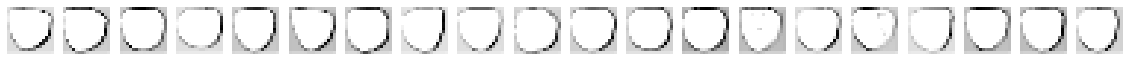

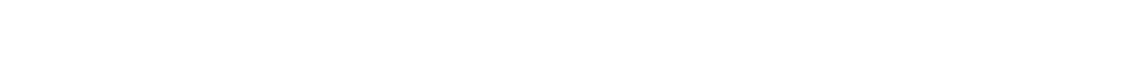

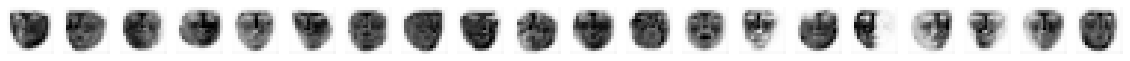

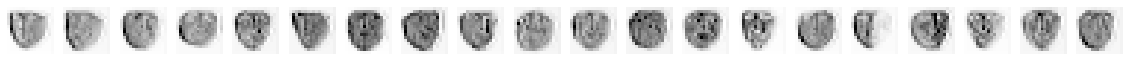

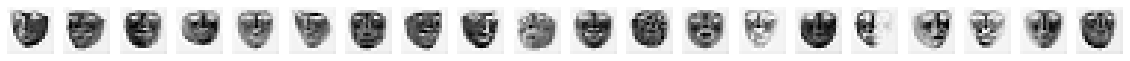

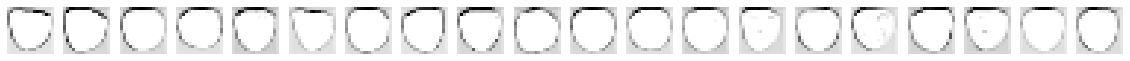

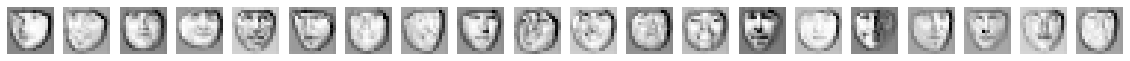

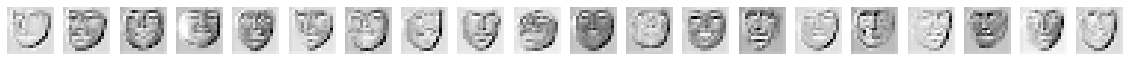

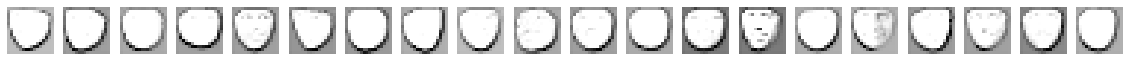

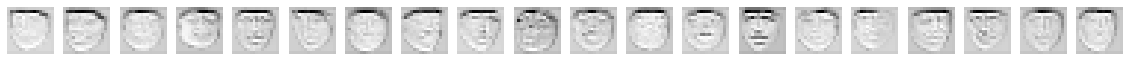

In [22]:
for i in range(encode_dim):
    Plot_Img_1c(20,16,FC_values_train_10[:,:,i],20,4)

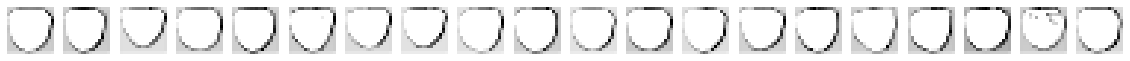

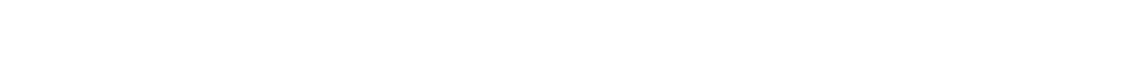

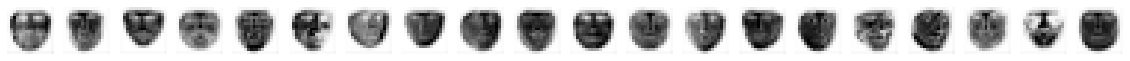

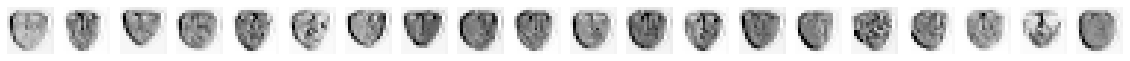

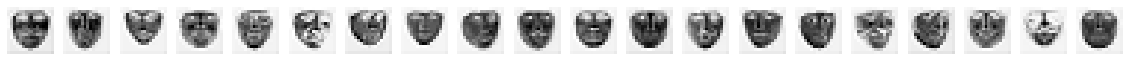

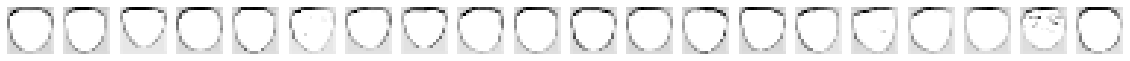

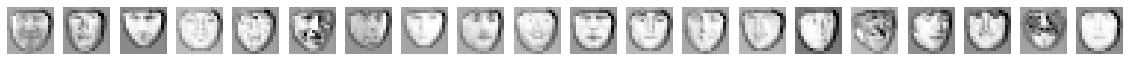

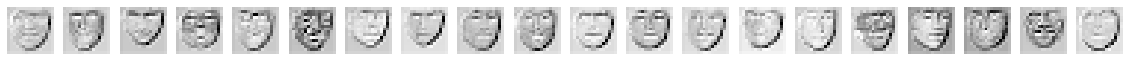

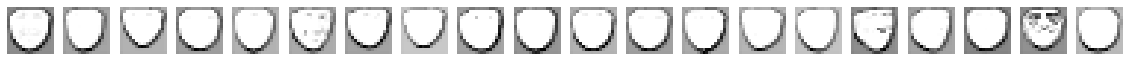

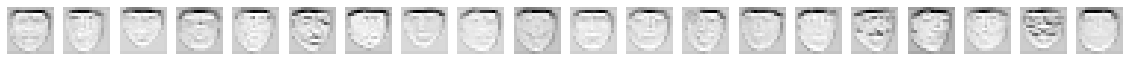

In [23]:
for i in range(encode_dim):
    Plot_Img_1c(20,16,FC_values_test_10[:,:,i],20,4)

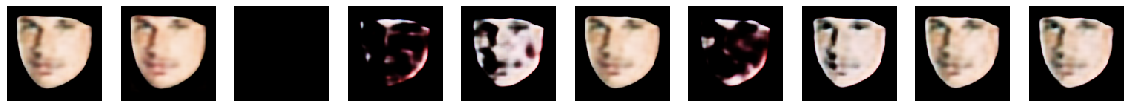

In [50]:
plt.figure(figsize=(20,8))
for i in range(10):
  FC_values_train_10 = encoder_10.predict(im_train)
  im_fc = FC_values_train_10[0:1,:,:]
  im_fc_mean = np.mean(im_fc[:,:,i])
  im_fc_sd = np.sqrt(np.var(im_fc[:,:,i]))
  for j in range(256):
      im_fc[:,j,0][0] = np.random.normal(im_fc_mean,im_fc_sd/4)
  decoded_im = decoder_10.predict(im_fc)
  ax = plt.subplot(1,10,i+1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.imshow(decoded_im[0])

**Variational Autoencoder**

In [0]:
from keras import backend as K
from keras import metrics

In [0]:
input_dim = [128,128,3] # The length of the input vector
inter_latent_dim = 1024
latent_dim = 5 # The length of the compressed data vector after the encoding
batch_size = 25 # Number of samples used to back-prop every time
epsilon_std = 0.5
epsilon = 0.1

In [0]:
#Input = layers.Input(batch_shape=(batch_size,input_dim[0],input_dim[1],input_dim[2]))
Input = layers.Input(shape=(input_dim[0],input_dim[1],input_dim[2]))
x = layers.Conv2D(16,(3,3),activation='relu',padding='same')(Input)
x = layers.MaxPooling2D((2,2),padding='same')(x)
x = layers.Conv2D(32,(3,3),activation='relu',padding='same')(x)
x = layers.MaxPooling2D((2,2),padding='same')(x)
x = layers.Conv2D(64,(3,3),activation='relu',padding='same')(x)
x = layers.MaxPooling2D((2,2),padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(inter_latent_dim,activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

In [0]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(latent_dim,),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [168]:
x = layers.Dense(inter_latent_dim,activation='relu')(z)
x = layers.Reshape((16,16,int(inter_latent_dim/(16*16))))(x)
x = layers.Conv2D(64,(3,3),activation='relu',padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(32,(3,3),activation='relu',padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(16,(3,3),activation='relu',padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
decode_z = layers.Conv2D(3,(3,3),activation='sigmoid',padding='same')(x)

vae = Model(Input,decode_z)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 128, 128, 16) 448         input_37[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_40 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_72[0][0]                  
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 64, 64, 32)   4640        max_pooling2d_40[0][0]           
__________________________________________________________________________________________________
max_poolin

In [169]:
# encoder, from inputs to latent space
encoder_z = Model(Input, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = layers.Input(shape=(latent_dim,))
x = vae.layers[12](decoder_input)
x = vae.layers[13](x)
x = vae.layers[14](x)
x = vae.layers[15](x)
x = vae.layers[16](x)
x = vae.layers[17](x)
x = vae.layers[18](x)
x = vae.layers[19](x)
x = vae.layers[20](x)
decoder_z = Model(decoder_input,x)

encoder_z.summary()
decoder_z.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 64)        0         
__________

In [0]:
def vae_loss(x, decode_z):
    x = K.flatten(x)
    decode_z = K.flatten(decode_z)
    xent_loss = metrics.binary_crossentropy(x, decode_z)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [171]:
vae.fit(im_train,im_train,epochs=100,batch_size=25)

Epoch 1/100
750/750 [==============================] - 5s 6ms/step - loss: 1.9529
Epoch 2/100
750/750 [==============================] - 2s 3ms/step - loss: 0.4276
Epoch 3/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3883
Epoch 4/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3761
Epoch 5/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3720
Epoch 6/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3698
Epoch 7/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3682
Epoch 8/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3678
Epoch 9/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3662
Epoch 10/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3657
Epoch 11/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3650
Epoch 12/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3649
Epoch 13/100


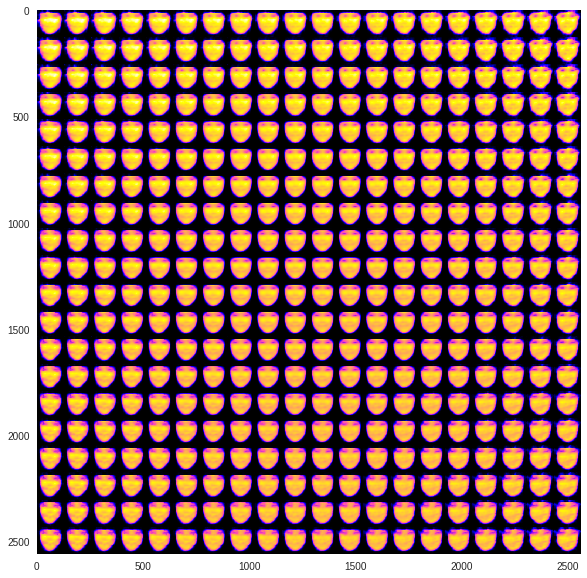

In [180]:
# display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digit_size = 128
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-10, 10, n)
grid_y = np.linspace(-10, 10, n)
x3 = 1
x4 = 1
x5 = 1

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi, x3, x4, x5]]) * epsilon_std
        x_decoded = decoder_z.predict(z_sample)
        digit = x_decoded[0][:,:,0].reshape(digit_size,digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()

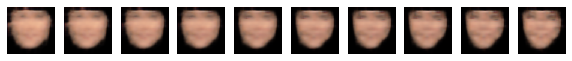

In [185]:
n = 10
generates = []
grid_x = np.linspace(-10, 10, n)
grid_y = np.linspace(-10, 10, n)
for xi in grid_x:
    for yi in grid_y:
        z_sample = np.array([[xi, yi, 1, 1, 1]]) * epsilon_std
        x_decoded = decoder_z.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size,digit_size,3)
        generates.append(digit)
Plot_Img(10,128,3,generates,10,4)